In [1]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import sys, os
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from sklearn.metrics import f1_score, recall_score, precision_score

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-08 19:57:46.753457: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-08 19:57:46.755758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-08 19:57:46.755776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Functions

In [2]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(18,6))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()
    # return ax

## Load & Preprocess Data

In [3]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
# df = df.asfreq(freq='T')
# df = df.interpolate()
df['label'] = df.label.astype(int)

In [4]:
df['lag_1'] = df['value'].shift(1)
df['lag_2'] = df['value'].shift(2)
df.fillna(0, inplace=True)

In [5]:
# df_hourly = df.resample('H').mean()

In [6]:
# Create a TimeSeries, specifying the time and value columns
# Set aside the last 20 percent of ts as a validation series
# series = TimeSeries.from_dataframe(df_hourly, value_cols='value')
# train, val = series[:-round(len(df_hourly) / 5)], series[-round(len(df_hourly) / 5):]

In [7]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
df['scaled'] = np_scaled
data = df[['value', 'lag_1', 'lag_2']]

## IsolationForest

In [8]:
outliers_fraction = float(.03)
if_model =  IsolationForest(contamination=outliers_fraction)
if_model.fit(data)

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.03)

In [9]:
if_prediction_df = df.copy()
if_prediction_df['anomaly'] = if_model.predict(data)
if_prediction_df['prediction'] = np.where(if_prediction_df['anomaly']==-1, 1, 0)
if_prediction_df['prediction'].value_counts()

0    124705
1      3857
Name: prediction, dtype: int64

#### Visualization

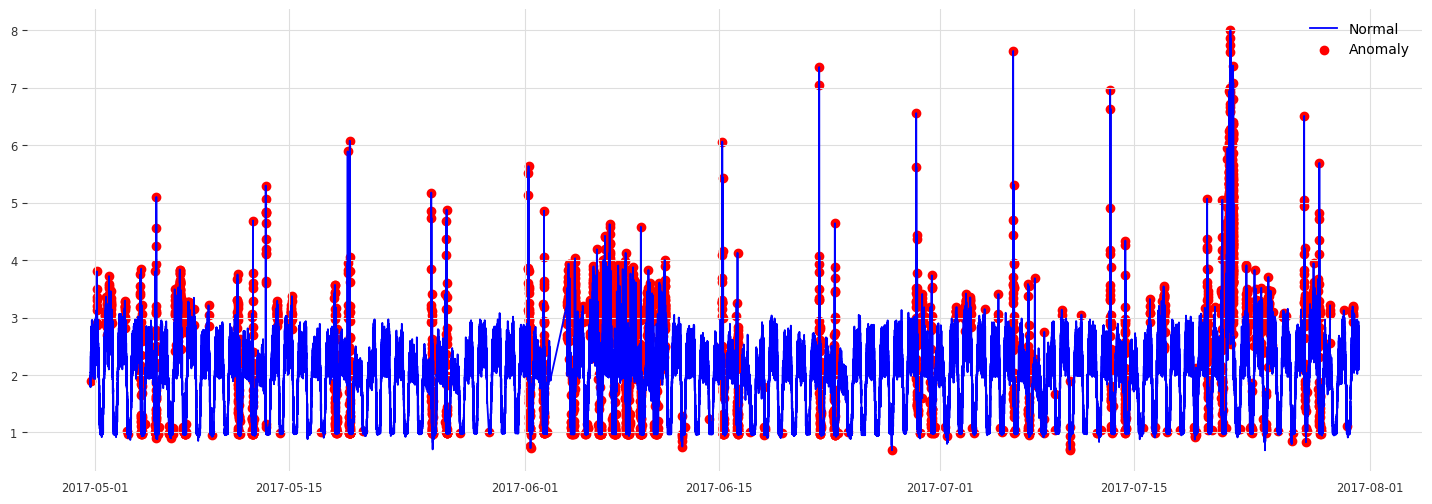

In [10]:
plot_outlier(if_prediction_df)

#### Metrics

In [11]:
f1_score(df['label'], if_prediction_df['prediction'])

0.41354896925105855

## KNN

In [12]:
outliers_fraction = float(0.03)
knn_model =  KNN(contamination=outliers_fraction)
knn_model.fit(data)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [13]:
knn_prediction_df = df.copy()
knn_prediction_df['anomaly'] = knn_model.predict(data)
knn_prediction_df['prediction'] = np.where(knn_prediction_df['anomaly']==1, 1, 0)
knn_prediction_df['prediction'].value_counts()

0    125073
1      3489
Name: prediction, dtype: int64

#### Visualization

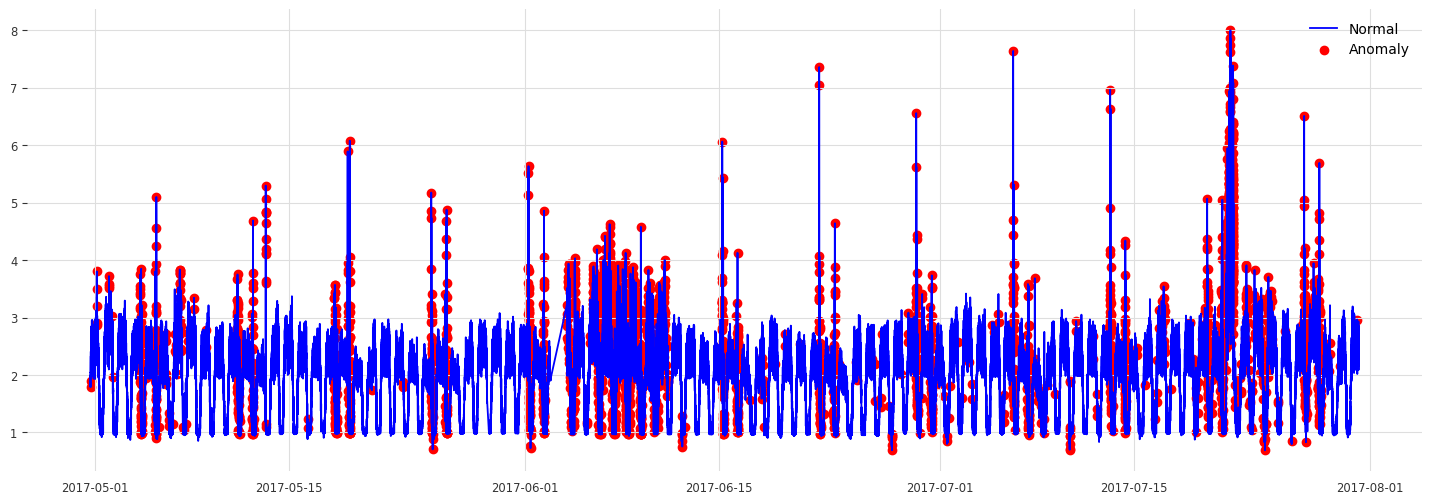

In [14]:
plot_outlier(knn_prediction_df)

#### Metrics

In [15]:
f1_score(df['label'], knn_prediction_df['prediction'])
# recall_score(df['label'], knn_prediction_df['prediction'])
# precision_score(df['label'], knn_prediction_df['prediction'])

0.42310705890732964

## DBSCAN

In [8]:
# dbscan_model = DBSCAN()
# dbscan_prediction_df = df.copy().tail(50000)
# dbscan_prediction_df['anomaly'] = dbscan_model.fit_predict(data.tail(50000))

In [9]:
# dbscan_prediction_df['prediction'] = np.where(dbscan_prediction_df['anomaly']==-1, 1, 0)
# dbscan_prediction_df['prediction'].value_counts()

0    50000
Name: prediction, dtype: int64

In [10]:
# f1_score(df['label'].tail(50000), dbscan_prediction_df['prediction'].tail(50000))
# recall_score(df['label'], knn_prediction_df['prediction'])
# precision_score(df['label'], knn_prediction_df['prediction'])

0.0